# Setup

### General Imports

In [14]:
import numpy as np
import pandas as pd
import gc
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec

# General settings
start_time = time.time()
color = sns.color_palette()
warnings.filterwarnings("ignore")

%matplotlib inline

### Spark Imports

In [4]:
from pyspark.sql import SparkSession

In [2]:
data_folder = "gs://ca4022_yelp_data/data_clean/"

In [5]:
spark = SparkSession.builder \
  .appName('Yelp! Ratings Analysis')\
  .getOrCreate()

# Analysis of the Distribution of Ratings

In [6]:
df_bus = spark.read.csv(data_folder + "business.csv", header=True, sep= ",", inferSchema=True)

The toPandas function allows us to easily inspect the Spark DataFrame as if it was a Pandas DataFrame, making it much more readable.

In [8]:
df_bus.limit(5).toPandas()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36.0,1.0,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4.0,1.0,"Health & Medical, Fitness & Instruction, Yoga,..."
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5.0,1.0,"Pets, Pet Services, Pet Groomers"
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3.0,0.0,"Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26.0,1.0,"Home Services, Plumbing, Electricians, Handyma..."


### Distribution of Star Ratings

The first step in our analysis is to plot the distribution of the star ratings.

In [11]:
stars_dist = df_bus.groupBy('stars').count().sort('stars').toPandas()

In [12]:
stars_dist

,stars,count
0,1.0,5898
1,1.5,6004
2,2.0,13124
3,2.5,21435
4,3.0,28633
5,3.5,38079
6,4.0,39198
7,4.5,29940
8,5.0,27080


Plotting the above...

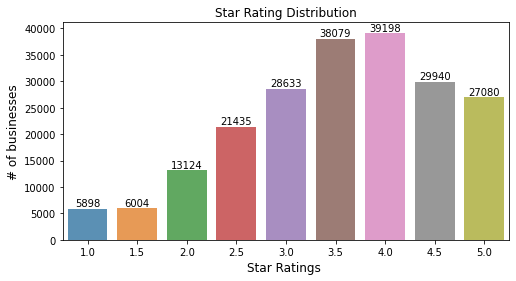

In [17]:
plt.figure(figsize=(8,4))
ax = sns.barplot(stars_dist["stars"], stars_dist["count"], alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

# Add text labels to each bar
rects = ax.patches
labels = stars_dist["count"]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

From this visualisation, we can see that the most popular average star rating for a business is 4.0, with nearly 40,000 businesses having this rating. The slight *negative skew* of this distribution also indicates that most businesses tend to have positive reviews on average.

An interesting next step would be to see which categories of businesses are the most popular.

### Top Business Categories

There are  1336  different types/categories of Businesses in Yelp!


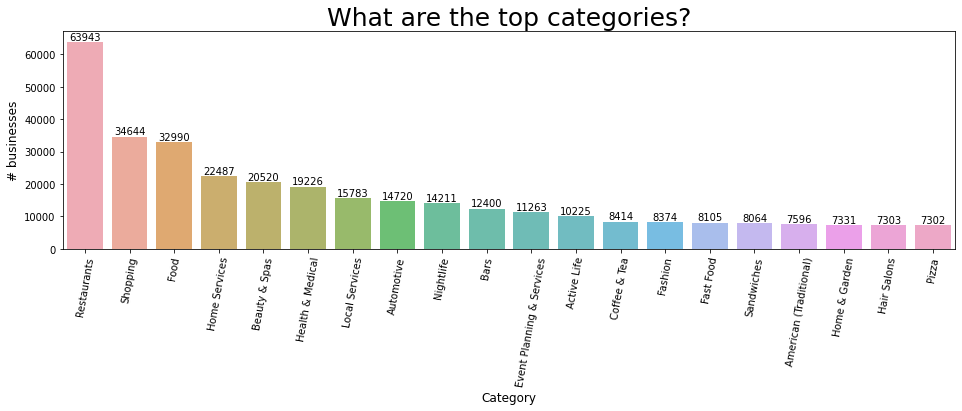

In [74]:
# What are the popular business categories?
pd_bus_cats = df_bus.toPandas()[["categories"]]
# Drop empty category fields
pd_bus_cats.dropna(axis=0, how="any", inplace=True)
bus_cats = ",".join(pd_bus_cats['categories'])

cats = pd.DataFrame(bus_cats.split(','),columns=['category'])
# Stripping any superflous whitespace chars
cats["category"] = cats["category"].str.strip()
cat_counts = cats.category.value_counts()
print("There are ",len(cat_counts)," different types/categories of Businesses in Yelp!")
# Plotting prep
cat_counts = cat_counts.sort_values(ascending=False)
cat_counts = cat_counts.iloc[0:20]

plt.figure(figsize=(16,4))
ax = sns.barplot(cat_counts.index, cat_counts.values, alpha=0.8)
plt.title("What are the top categories?", fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

# Add count label to each bar
rects = ax.patches
labels = cat_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Naturally, the highest number of businesses come from the 'Restaurants' category, as these would be most widely reviewed.